In [22]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from topostats.io import LoadScans
import topostats.filters as topofilters
from topostats.utils import get_mask
from skimage.filters import gaussian
from skimage.morphology import remove_small_objects, label
from skimage.measure import regionprops
from skimage import draw
from skimage import util
from topostats.theme import Colormap
import math
from scipy import ndimage as ndi
from skimage.segmentation import watershed
from skimage.feature import peak_local_max

In [6]:
cmap = Colormap("nanoscope").get_cmap()
def plot(image: np.ndarray, title: str=None, zlimit: bool=True, figsize: tuple=(8, 8), **kwargs) -> None:
    fig, ax = plt.subplots(figsize=figsize)
    if zlimit == True:
        vmin=-3
        vmax=4
    else:
        vmin=None
        vmax=None
    ax.imshow(image, vmin=vmin, vmax=vmax, cmap=cmap, **kwargs)
    if title is not None:
        ax.set_title(title)
    plt.show()

[Thu, 24 Aug 2023 11:45:57] [INFO    ] [topostats] Extracting image from PristineZoom\Mid\20230417_KPN0018_Metal.0_00005.spm
[Thu, 24 Aug 2023 11:45:57] [INFO    ] [topostats] Loading image from : PristineZoom\Mid\20230417_KPN0018_Metal.0_00005.spm
[Thu, 24 Aug 2023 11:45:57] [INFO    ] [topostats] [20230417_KPN0018_Metal.0_00005] : Loaded image from : PristineZoom\Mid\20230417_KPN0018_Metal.0_00005.spm
[Thu, 24 Aug 2023 11:45:57] [INFO    ] [topostats] [20230417_KPN0018_Metal.0_00005] : Extracted channel Height
[Thu, 24 Aug 2023 11:45:57] [INFO    ] [topostats] [20230417_KPN0018_Metal.0_00005] : Pixel to nm scaling : 4.150390625


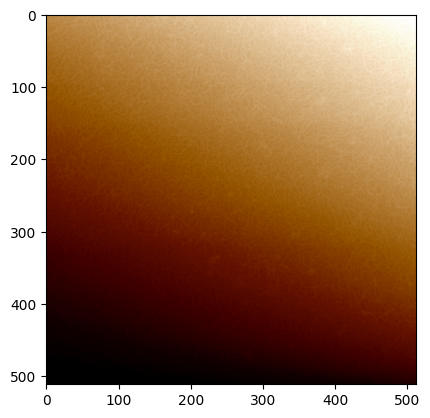

In [63]:
#Import SPM files
#file = Path('./PristineZoom/20230125_KPN005_25mMMgCl2_Vac.0_00009.spm')
#file = Path('./PristineZoom/20230126_KPN005_25mMMgCl2_Vac_24hr.0_00006.spm')
#file = Path('./EP_Zoom/20230419_EPN005_Metal.0_00006.spm')
file = Path('./PristineZoom/Mid/20230417_KPN0018_Metal.0_00005.spm')

loadscans = LoadScans([file], 'Height')
loadscans.get_data()
p_to_nm = loadscans.pixel_to_nm_scaling
image_raw = loadscans.image
plt.imshow(image_raw, cmap=cmap)

In [64]:
filters = topofilters.Filters(
    image = image_raw,
    filename = file,
    pixel_to_nm_scaling = p_to_nm,
    threshold_method='std_dev',
    row_alignment_quantile=0.05,
    threshold_std_dev={'upper': 1.0, 'lower': None},
    gaussian_size=1.0,
    remove_scars={'run': False}
)

filters.filter_image()

[Thu, 24 Aug 2023 11:46:01] [INFO    ] [topostats] [PristineZoom\Mid\20230417_KPN0018_Metal.0_00005.spm] : Median flattening without mask
[Thu, 24 Aug 2023 11:46:01] [INFO    ] [topostats] [PristineZoom\Mid\20230417_KPN0018_Metal.0_00005.spm] : Plane tilt removal without mask
[Thu, 24 Aug 2023 11:46:02] [INFO    ] [topostats] [PristineZoom\Mid\20230417_KPN0018_Metal.0_00005.spm] : x-polyfit 1st order: [ 0.03915974 -1.05113753]
[Thu, 24 Aug 2023 11:46:02] [INFO    ] [topostats] [PristineZoom\Mid\20230417_KPN0018_Metal.0_00005.spm] : y-polyfit 1st order: [6.50838842e-05 8.90912711e+00]
[Thu, 24 Aug 2023 11:46:02] [INFO    ] [topostats] [PristineZoom\Mid\20230417_KPN0018_Metal.0_00005.spm] : Removing x plane tilt
[Thu, 24 Aug 2023 11:46:02] [INFO    ] [topostats] [PristineZoom\Mid\20230417_KPN0018_Metal.0_00005.spm] : removing y plane tilt
[Thu, 24 Aug 2023 11:46:02] [INFO    ] [topostats] [PristineZoom\Mid\20230417_KPN0018_Metal.0_00005.spm] : Remove quadratic bow without mask
[Thu, 24 A

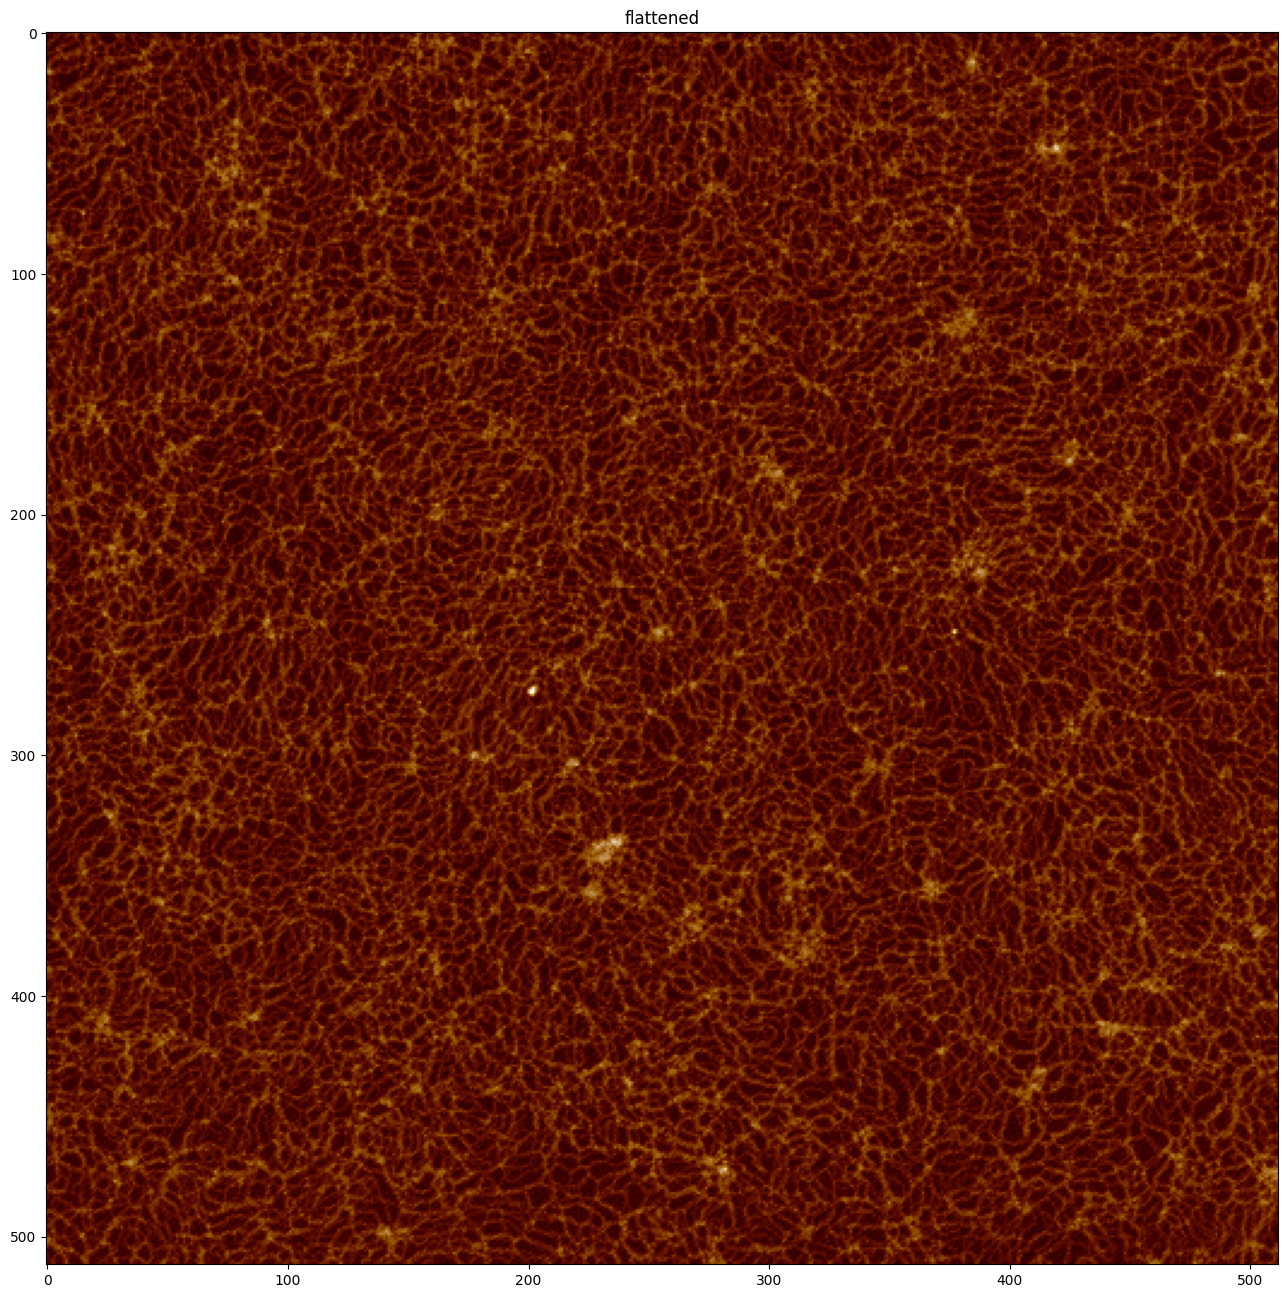

In [101]:
flattened = filters.images['zero_average_background']
plot(flattened, title='flattened',figsize=(16,16))

thresholds: defaultdict(None, {'upper': 0.1796149895759327})
[Thu, 24 Aug 2023 13:29:16] [INFO    ] [topostats] [None] : Masking (upper) Threshold: 0.1796149895759327


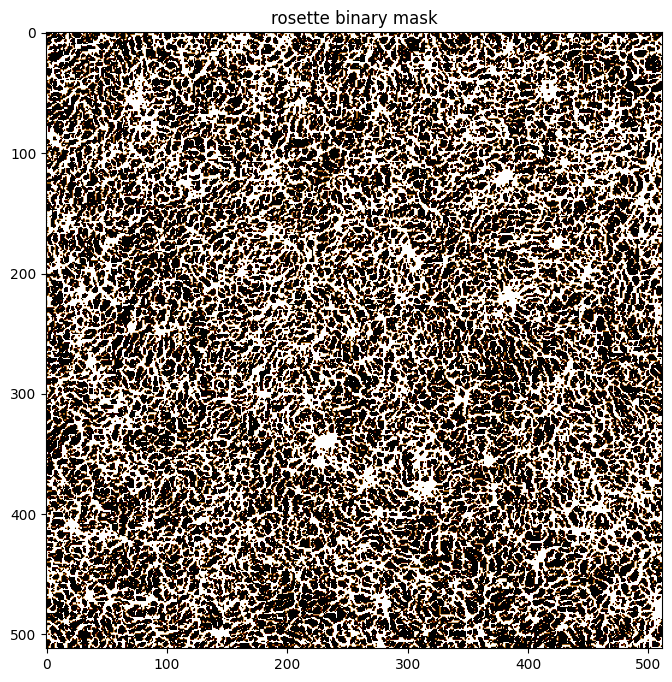

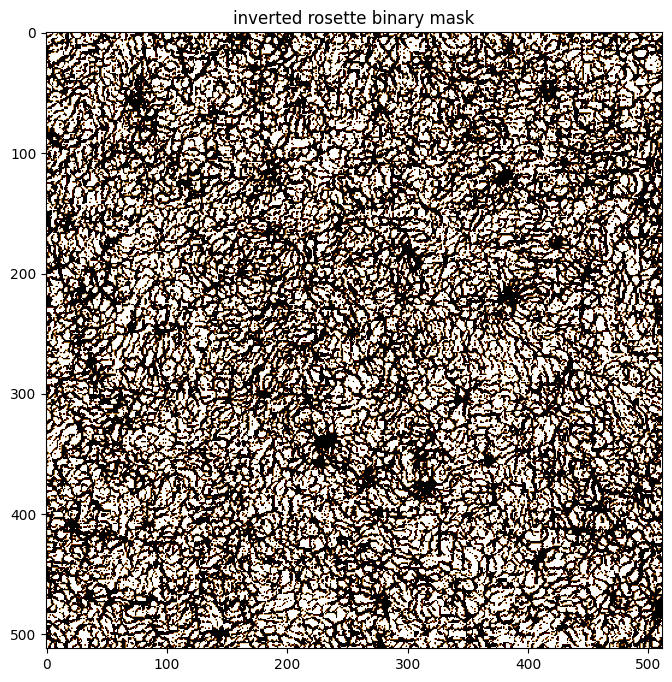

In [109]:
#Threshold

rosette_thresholds = topofilters.get_thresholds(
    flattened,
    threshold_method='std_dev',
    threshold_std_dev={'upper': 0.05, 'lower': None}
)

print(f'thresholds: {rosette_thresholds}')
rosette_mask = topofilters.get_mask(image=flattened, thresholds=rosette_thresholds)
plot(rosette_mask.astype(bool), title='rosette binary mask', zlimit=False)
inv_rosette_mask = util.invert(rosette_mask)
plot(inv_rosette_mask.astype(bool), title='inverted rosette binary mask', zlimit=False)


In [103]:
distance = ndi.distance_transform_edt(inv_rosette_mask)
coords = peak_local_max(distance, footprint=np.ones((3, 3)), labels=inv_rosette_mask)
mask = np.zeros(distance.shape, dtype=bool)
mask[tuple(coords.T)] = True
markers, _ = ndi.label(mask)
grains = watershed(-distance, markers, mask=inv_rosette_mask)


Text(0.5, 1.0, 'Separated objects')

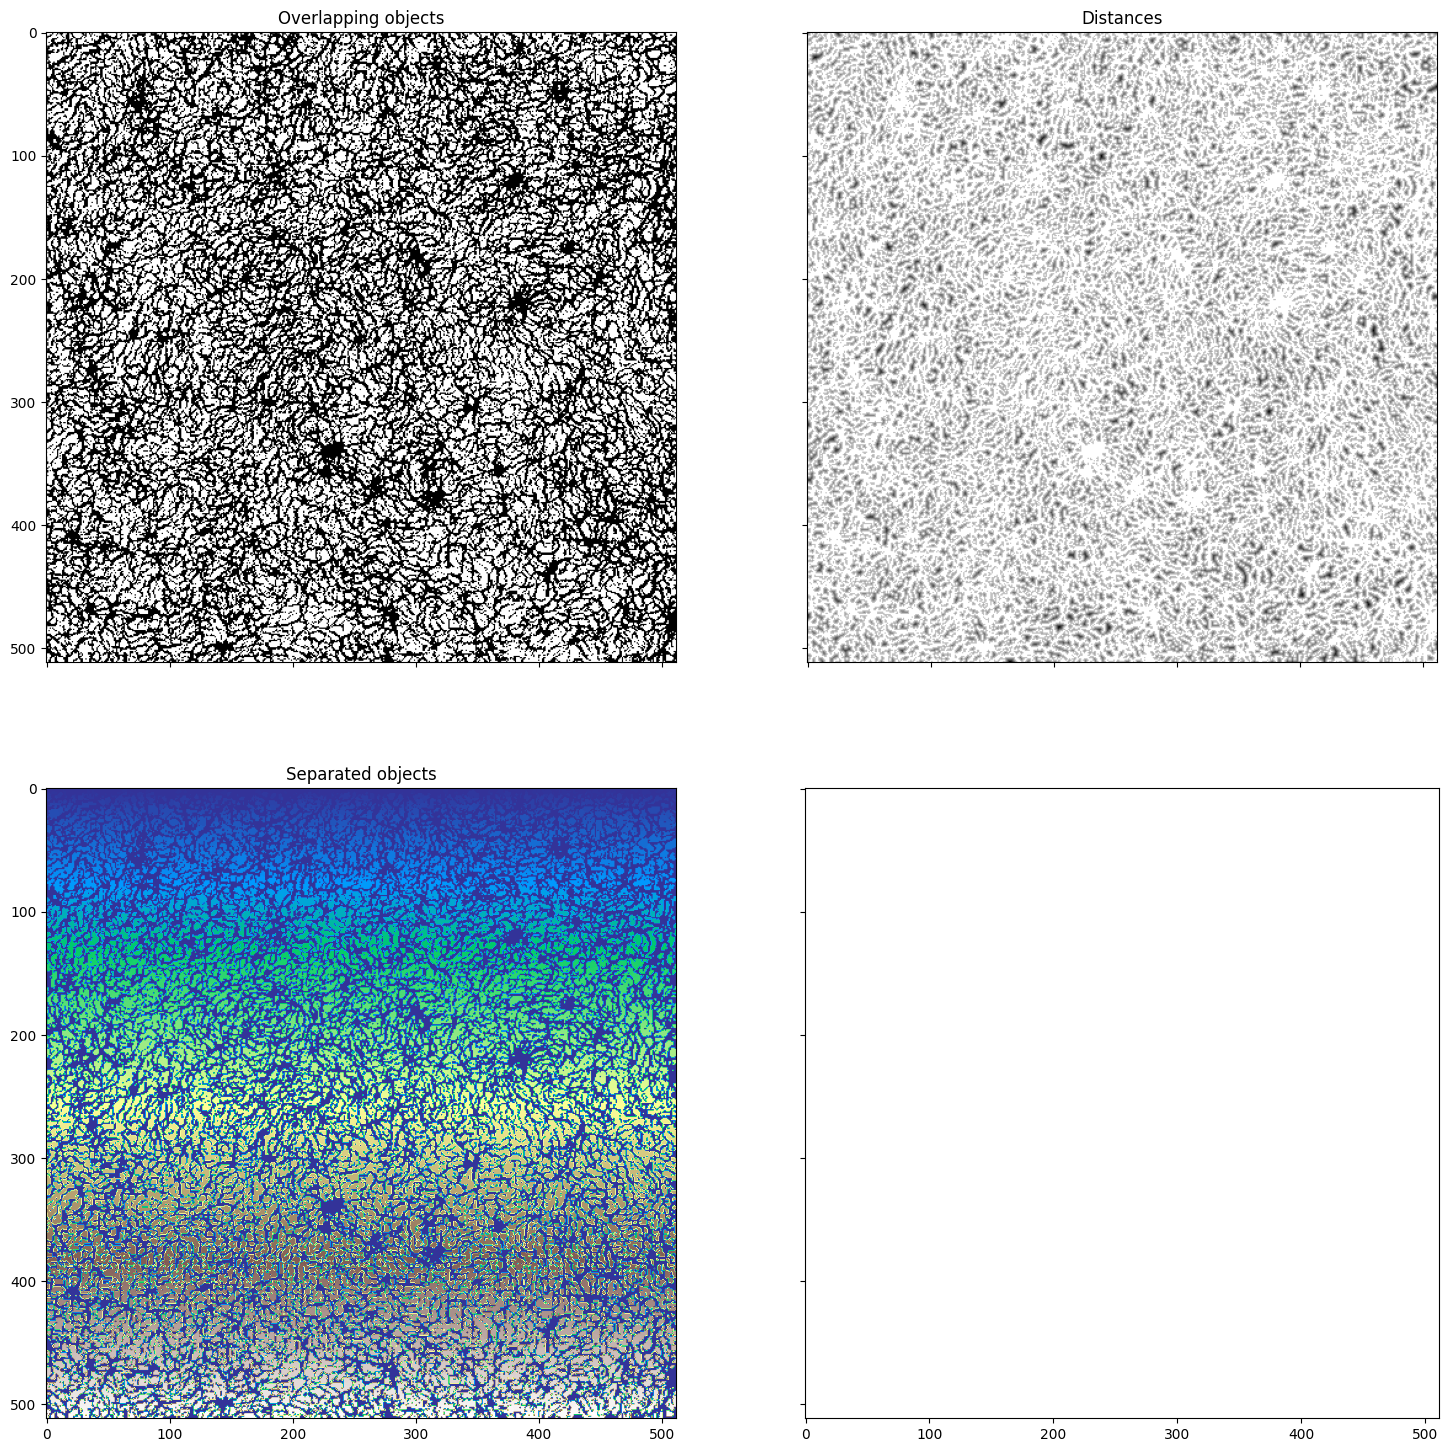

In [114]:
fig, axes = plt.subplots(ncols=2,nrows=2,figsize=(18, 18), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(inv_rosette_mask, cmap=plt.cm.gray)
ax[0].set_title('Overlapping objects')
ax[1].imshow(-distance, cmap=plt.cm.gray)
ax[1].set_title('Distances')
ax[2].imshow(grains, cmap=plt.cm.terrain)
ax[2].set_title('Separated objects')
#ax[3].imshow(grains[1], cmap=plt.cm.nipy_spectral)
#ax[3].set_title('Separated objects filtered')


In [105]:
region_props = regionprops(grains)
areas = np.zeros(len(region_props))

for props_index, props in enumerate(region_props):
        areas[props_index] = props.area
areas_nm = areas*p_to_nm
diameter_nm = np.sqrt(areas_nm)
print("Mean Pore Area: ",np.mean(areas_nm))
print("Median Pore Area: ",np.median(areas_nm))
print("Mean Pore Diameter: ",np.mean(diameter_nm))
print("Median Pore Diameter: ",np.median(diameter_nm))


Mean Pore Area:  29.278842843180854
Median Pore Area:  20.751953125
Mean Pore Diameter:  4.918537339859756
Median Pore Diameter:  4.555431167847891


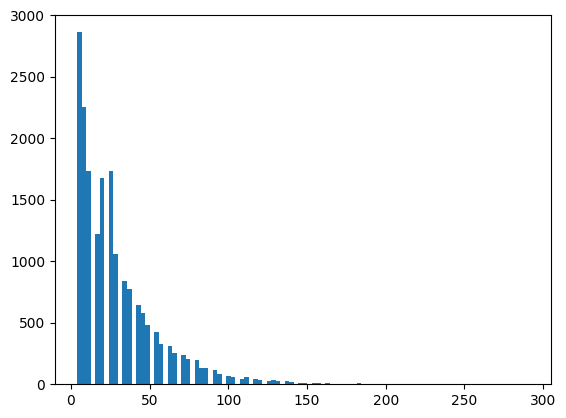

In [106]:
fig, ax = plt.subplots()
ax.hist(areas_nm, bins=100)
plt.show()

In [69]:
#Only use if on the fibril
"""
# Remove small objects
removed_small_objects = remove_small_objects(grains, 1)
# Remove large objects
labelled_grain_mask = label(removed_small_objects)
regions = regionprops(labelled_grain_mask)
for props_index, props in enumerate(regions):
    if props.area > 25:
        labelled_grain_mask[labelled_grain_mask==props.label] = 0
"""

'\n# Remove small objects\nremoved_small_objects = remove_small_objects(grains, 1)\n# Remove large objects\nlabelled_grain_mask = label(removed_small_objects)\nregions = regionprops(labelled_grain_mask)\nfor props_index, props in enumerate(regions):\n    if props.area > 25:\n        labelled_grain_mask[labelled_grain_mask==props.label] = 0\n'